In [199]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from tqdm import tqdm
import random
import math

# set the seed for reproducibility
SEED = 42
np.random.seed(SEED)

from utils import *
from gen import test, random_search, true_random_search, true_random_nsteps


In [200]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "complex_maze.des",
    max_episode_steps=10000,
)
state = env.reset()
env.render()


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                   -----------------                            
                     ----------    |...............|                            
                     |........|    |............|..|                            
                     |........|    |............|..|                            
                     ------...|    |..-----..----..|                            
                          |...|    |..|   |........|                            
                          |...|    |..|   |........|  ------                    
                    -------...------..|   |.....----  |....|                    
                    |.................|   |.....|     |....|                    
                    |..-----....|..|..|   |.....-------....|                    
                    |..|   

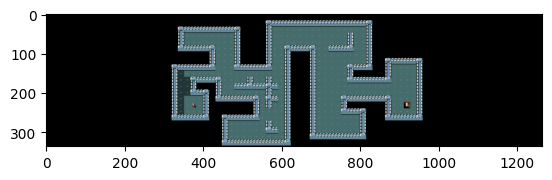

In [201]:
plt.imshow(state['pixel'])

In [202]:
game_map = state['chars']
game = state['pixel']
start = get_player_location(game_map)
target = get_target_location(game_map)

In [203]:
a = (0, -1)
b = (0, 1)
c = (1, 0)      
d = (-1, 0)

ACTIONS = [a, b, c, d]

def modify_action(t1, t2):
    """Sum two tuples"""
    return (t1[0] + t2[0], t1[1] + t2[1])

def is_crossoverable(action1, action2):
    # if action 1 and action 2 are oblique, return False
    dx = abs(action1[0] - action2[0])
    dy = abs(action1[1] - action2[1])
    # return false if the two components are changing together and > 1
    if (dx > 0 and dy > 0) and (dx > 1 or dy > 1):
        return False
    else:
        print(f'actions: ,{action1, action2}')
        return True

def crossover(path1, path2):
    """Crossover two paths"""
    # randomly select a crossover point
    i = np.random.randint(1, min(len(path1), len(path2)))
    while not is_crossoverable(path1[i-1], path2[i]):
        i = np.random.randint(1, min(len(path1), len(path2)))

    # return the two paths joined at the crossover point
    # TODO:  implement controls on move validity

    # return path1[:i+1] + path2[i:]

    # until the path is valid, merge the 2 path
    print(f'point of crossover: {i}')
    print(f'path1: {path1}')
    print(f'path2: {path2}')
    print(f'lenp1: {len(path1[:i])}, path1[:i]: {path1[:i]}')
    print(f'lenp2: {len(path2[i:])}, path2[i:]: {path2[i:]}')
    pathtry = path1[:i] + path2[i:]

    #concatenete path1 and path2

    for idx in range(1, len(pathtry)):
        if is_wall(game_map[pathtry[idx]]):
            #truncate here pathtry[:idx]
            return path1[:i] + path2[i:idx-1]
    return pathtry

def mutate(path, mutation_rate=0.05):
    """Mutate a path"""
    # randomly select n postions to mutate
    print(f'before mutation {path}')
    actions = actions_from_path(start, path[1:])
    idxs = random.sample(list(range(len(actions))), k = math.floor(len(actions)/10))
    print("idxs", idxs)
    # randomly select new actions for each position and replace
    # TODO?  implement controls on move validity
    for idx in idxs:
        print(f"valid moves:", get_valid_actions(game_map, path[idx]))
        print(game_map[path[idx]])
        action = random.choice(get_valid_actions(game_map, path[idx]))
        actions[idx] = action
    path = path_from_actions(path[0], actions)
    print(f'after mutation {path}')
    return path

In [204]:
start

(14, 23)

In [205]:
math.ceil(2.4)

3

In [206]:


MAX_GENERATIONS = 10
MAX_INDIVIDUALS = 50

best_scores =[]
best_paths = []

state = env.reset()
"""env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "complex_maze.des",
    max_episode_steps=10000,
)
state = env.reset()
env.render()"""

# this is manhattan distance from the last element of the path to the target
fitness_function = lambda path: abs(path[-1][0] - target[0]) + abs(path[-1][1] - target[1])

# create a list of individuals, starting with random moves (illegal actions filtered out)
print("> Creating initial population...")
individuals = [true_random_nsteps(game_map, start, target) for _ in range(MAX_INDIVIDUALS)]
best_fitness = np.inf

# create a list of tuples (individual, fitness)
print("> Evolving...")
for generation in tqdm(range(MAX_GENERATIONS), postfix=f'best score: {best_fitness:.2f}'):
    
    state = env.reset()
    
    generation_scores = []
    
    fitnesses = [fitness_function(individual) for individual in individuals]
    generation_scores.append(min(fitnesses))

    # this is a list of tuples (individual, fitness). individual is a list of moves
    population = list(zip(individuals, fitnesses))

    # sorting the population by best fitness (lower is better)
    population.sort(key=lambda x: x[1])
    print(f"best score: {population[0][1]:.2f}")
    # take 2 best individuals -> maybe can be replaced with probability distribution based on fitness
    # also roulette wheel selection.
    child1, child2 = population[0], population[1]
    #print(f"len1:{len(child1[0])}\tlen2:{len(child2[0])}")
    offspring = [crossover(child1[0], child2[0]) for _ in range(MAX_INDIVIDUALS)]
    offspring = [mutate(child) for child in offspring]
    individuals = offspring
    best_fitness = population[0][1]
    best_scores.append(population[0][1])    
    best_paths.append(population[0][0])
    #print(f"Generation {generation}: best score {best_fitness:.2f}")
    

> Creating initial population...
> Evolving...


  0%|          | 0/10 [00:00<?, ?it/s, best score: inf]

 10%|█         | 1/10 [00:00<00:00, 19.75it/s, best score: inf]

best score: 32.00
actions: ,((13, 22), (13, 23))
point of crossover: 33
path1: [(14, 23), (14, 22), (14, 21), (13, 21), (12, 21), (12, 22), (13, 22), (14, 22), (13, 22), (13, 21), (14, 21), (14, 22), (14, 21), (14, 22), (13, 22), (12, 22), (11, 22), (12, 22), (11, 22), (11, 21), (11, 22), (11, 21), (10, 21), (9, 21), (10, 21), (11, 21), (12, 21), (13, 21), (14, 21), (13, 21), (12, 21), (12, 22), (13, 22), (13, 21), (12, 21), (11, 21), (10, 21), (10, 22), (11, 22), (10, 22), (9, 22), (9, 23), (9, 24), (9, 25), (9, 26), (9, 27), (8, 27), (7, 27), (8, 27), (9, 27), (9, 28), (9, 29), (9, 30), (9, 29), (10, 29), (10, 28), (11, 28), (12, 28), (12, 29), (11, 29), (10, 29), (10, 28), (10, 29), (9, 29), (10, 29), (11, 29), (12, 29), (12, 28), (12, 29), (12, 30), (12, 29), (12, 30), (12, 31), (12, 30), (12, 29), (11, 29), (11, 28), (10, 28), (11, 28), (12, 28), (12, 29), (11, 29), (11, 28), (11, 29), (10, 29), (10, 30), (9, 30), (9, 31), (10, 31), (10, 30), (9, 30), (9, 29), (8, 29), (7, 29), (8

IndexError: list index out of range

In [ ]:
# for every individual, print its fitness and the path
for individual, fitness in population:
    print(f"Fitness: {fitness:.2f}")


Fitness: 32.00
Fitness: 34.00
Fitness: 34.00
Fitness: 34.00
Fitness: 34.00
Fitness: 34.00
Fitness: 34.00
Fitness: 34.00
Fitness: 34.00
Fitness: 34.00
Fitness: 34.00
Fitness: 34.00
Fitness: 34.00
Fitness: 34.00
Fitness: 34.00
Fitness: 34.00
Fitness: 36.00
Fitness: 36.00
Fitness: 36.00
Fitness: 36.00
Fitness: 36.00
Fitness: 36.00
Fitness: 36.00
Fitness: 36.00
Fitness: 36.00
Fitness: 36.00
Fitness: 36.00
Fitness: 36.00
Fitness: 36.00
Fitness: 36.00
Fitness: 36.00
Fitness: 36.00
Fitness: 36.00
Fitness: 38.00
Fitness: 38.00
Fitness: 38.00
Fitness: 38.00
Fitness: 38.00
Fitness: 38.00
Fitness: 38.00
Fitness: 38.00
Fitness: 38.00
Fitness: 38.00
Fitness: 38.00
Fitness: 40.00
Fitness: 40.00
Fitness: 40.00
Fitness: 40.00
Fitness: 40.00
Fitness: 40.00


KeyboardInterrupt: 

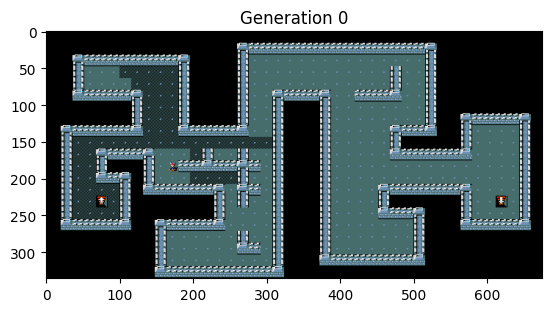

In [ ]:
image = plt.imshow(game[:, 300:975])
for generation, path in enumerate(best_paths):
    plt.title(f"Generation {generation}")
    start = path[0]
    path = path[1:]
    actions = actions_from_path(start, path)
    env.reset()
    for action in actions:
        s, _, _, _ = env.step(action)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        image.set_data(s['pixel'][:, 300:975])
    